In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

import sys
import os
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pybel
from rdkit.Chem import AllChem, DataStructs, SDMolSupplier, Draw
from rdkit.Chem.Draw import IPythonConsole


In [2]:

def morgan(dir, bit_length=512):
    morgan = []
    names = []
    ret_arr = []
    bitInfo_arr = []
    mol_arr = []
    dir = "../data/sdf/master.sdf"
    temp_str = "ls " + dir
    temp = os.popen(temp_str).read()
    temp = str(temp).split()
    mols = [ i for i in SDMolSupplier(dir)]


    for i, suppl in enumerate(mols):
        try:
            bitInfo = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(suppl, 2, bitInfo=bitInfo,nBits=int(bit_length))
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            ret_arr.append(arr)
            morgan.append(fp)
            names.append(suppl.GetProp("NAME"))
            bitInfo_arr.append(bitInfo)

            sys.stdout.write("\r %s / " % i + str(len(mols)))
            sys.stdout.flush()
        except:
            pass

    morgan = np.array(morgan)
    print("successfully processed " + str(i) + " out of " + str(len(temp)) + " molecules")
    return names, morgan, ret_arr, bitInfo_arr, mols


In [3]:

def process_input_DB3(name, mat):

    mat = list(mat)
    temp_dict = {"name": name, "mat": mat}
    df = pd.DataFrame.from_dict(temp_dict, orient="index")
    df = df.transpose()
    list_to_sort = []

    with open("../data/DATA_DB3_transform") as fp:
        line = fp.readline()
        while line:
            list_to_sort.append(line[0:-2])
            line = fp.readline()

    list_to_sort.sort()
    print("done processing lines of data file")
    df["HOMO"] = 0
    df["HOMO-1"] = 0
    df["diff"] = 0
    track = 0
    for i in range(df.shape[0]):
        trip = 0
        for j in list_to_sort:
            #print(df["name"].iloc[i][0:-4])
            #print(j.split(":")[0])
            if (df["name"].iloc[i][0:-4] in j.split(":")[0] and j[0:2] != "--"):
                temp1 = float(j.split(":")[1])
                temp2 = float(j.split(":")[2])
                track +=1
                df["HOMO"].loc[i] = temp1
                df["HOMO-1"].loc[i] = temp2
                df["diff"].loc[i] = temp2 - temp1
                break

    print("done parsing energies")
    return df


In [4]:

def xgboost(x_train, x_test, y_train, y_test, scale, dict=None):

    params = {
        "colsample_bytree": 0.5,
        "learning_rate": 0.1,
        "max_depth": 10, "gamma": 0.00,
        "lambda": 0.0,
        "alpha": 0,
        "eta": 0.01,
        "n_estimators": 2000}

    reg = xgb.XGBRegressor(**params, objective="reg:squarederror", tree_method="gpu_hist")

    params = {"max_depth":40,
              "n_estimators": 5000,
              "min_samples_split": 3,
              "n_jobs": 16,
              "verbose": False
              }
    reg = RandomForestRegressor(**params)

    t1 = time.time()
    # non grid
    print(y_train)
    reg.fit(x_train, y_train)
    t2 = time.time()

    time_el = t2 - t1
    score = reg.score(x_test, y_test)
    print("xgboost score:               " + str(score) + " time: " + str(time_el))
    score = str(mean_squared_error(reg.predict(x_test), y_test))
    print("MSE score:   " + str(score))
    score = str(mean_absolute_error(reg.predict(x_test), y_test))
    print("MAE score:   " + str(score))
    score = str(r2_score(reg.predict(x_test), y_test))
    print("r2 score:   " + str(score))
    score = str(r2_score(reg.predict(x_train), y_train))
    print("r2 score:   " + str(score))
    score_mae = mean_absolute_error(reg.predict(x_test), y_test)
    print("scaled MAE")
    print(scale * score_mae)
    return reg


In [5]:
names, morganArr, retArr, bitInfoArr, molArr = morgan(dir = dir,bit_length = 1024)

print("input begun with processing dataframe")

#print(names)
df = process_input_DB3(names, morganArr)
#print(df["diff"])
#print(df["mat"])

 606 / 6992

RDKit ERROR: [11:21:03] ERROR: EOF hit while reading atoms


 2998 / 6992

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6990 / 6992successfully processed 6991 out of 1 molecules
input begun with processing dataframe
done processing lines of data file


/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


done parsing energies


In [6]:
mat = list(df["mat"])
mat = preprocessing.scale(np.array(mat))
scale = np.max(np.array(df["HOMO"])) - np.min(np.array(df["HOMO"]))


/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [7]:
x = np.array(mat)
y = np.array(np.array(df["HOMO"]))
indices = range(len(x))
try:
    x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices, test_size=0.2, random_state=42)
except:
    x = list(x)
    x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices, test_size=0.2, random_state=42)

reg = xgboost(x_train, x_test, y_train, y_test, scale)


[-0.209508 -0.196427 -0.201781 ... -0.212307 -0.186965 -0.193405]
xgboost score:               0.7191590604248832 time: 108.74869227409363
MSE score:   2.672450012220208e-05
MAE score:   0.0025891339458442957
r2 score:   0.6080253334443513
r2 score:   0.9562357537618412
scaled MAE
0.000268019378671964


In [8]:
fimportance = reg.feature_importances_
fimportance_dict = dict(zip(range(1024), fimportance))
sorteddata = sorted(fimportance_dict.items(), key=lambda x: -x[1])
top25feat = [x[0] for x in sorteddata][:25]
top50feat = [x[0] for x in sorteddata][:50]


In [9]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print([i for i in take(10,sorteddata)])


[(715, 0.27732461898934163), (674, 0.04664249573830094), (392, 0.03748563744432405), (1016, 0.03705496800128704), (319, 0.02865916855081125), (452, 0.025176443937250794), (746, 0.024933453798229387), (318, 0.019518240586300164), (112, 0.018755161085606417), (967, 0.015053079698770051)]


In [10]:
print(top25feat)

[715, 674, 392, 1016, 319, 452, 746, 318, 112, 967, 628, 271, 360, 673, 390, 175, 77, 397, 747, 286, 726, 587, 389, 80, 790]


In [11]:
print(top25feat)

[715, 674, 392, 1016, 319, 452, 746, 318, 112, 967, 628, 271, 360, 673, 390, 175, 77, 397, 747, 286, 726, 587, 389, 80, 790]


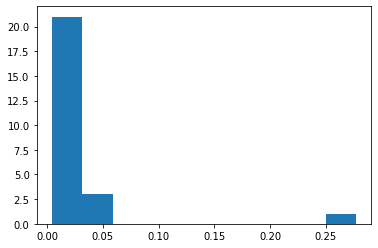

[715, 674, 392, 1016, 319, 452, 746, 318, 112, 967, 628, 271, 360, 673, 390, 175, 77, 397, 747, 286, 726, 587, 389, 80, 790]


In [12]:
top50feat = [x[0] for x in sorteddata][:50]
top10feat = [x[0] for x in sorteddata][:10]

plt.hist([i[1] for i in take(25,sorteddata)])
plt.show()
print(top25feat)

[715, 674, 392, 1016, 319, 452, 746, 318, 112, 967, 628, 271, 360, 673, 390, 175, 77, 397, 747, 286, 726, 587, 389, 80, 790]
[0.27732461898934163, 0.04664249573830094, 0.03748563744432405, 0.03705496800128704, 0.02865916855081125, 0.025176443937250794, 0.024933453798229387, 0.019518240586300164, 0.018755161085606417, 0.015053079698770051, 0.012353168584668015, 0.01185651348138301, 0.011411372526475233, 0.0084642681587781, 0.00834299769640479, 0.007820507035937469, 0.007789322144436417, 0.007724563082040195, 0.007181172646647209, 0.006665950322882985, 0.005181005444410606, 0.004890748496852126, 0.004663481906752974, 0.004617261883781911, 0.004263824673247402, 0.004162664939796931, 0.003950135853585698, 0.003784608531331908, 0.003429982983813701, 0.003407404082253125, 0.003339366838661374, 0.0033047025368392858, 0.0032956788849687656, 0.0032249202530624495, 0.003179182979382214, 0.0031644323554710285, 0.0030739211166289, 0.003062855912970699, 0.003060472498672535, 0.0029890830133413133, 

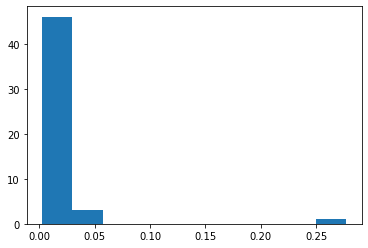

In [13]:
print(top25feat)
print([sorteddata[i][1] for i in range(50)])
plt.hist([sorteddata[i][1] for i in range(50)])
plt.show()


In [14]:
print(top25feat)

[715, 674, 392, 1016, 319, 452, 746, 318, 112, 967, 628, 271, 360, 673, 390, 175, 77, 397, 747, 286, 726, 587, 389, 80, 790]


In [15]:
testidx = np.argsort(y_test)
print(sorted(y_test))
print(testidx)
print(len(testidx))
slice_conv = tuple(slice(x) for x in testidx)

[-0.233078, -0.231871, -0.231579, -0.2309, -0.229912, -0.229723, -0.228843, -0.228035, -0.227637, -0.225606, -0.225356, -0.225307, -0.224949, -0.224612, -0.224424, -0.224414, -0.224334, -0.223943, -0.223453, -0.223177, -0.222983, -0.222613, -0.222574, -0.222477, -0.222392, -0.222274, -0.222101, -0.221958, -0.221903, -0.221877, -0.221828, -0.221765, -0.221708, -0.2217, -0.221551, -0.221494, -0.221284, -0.221284, -0.221208, -0.220828, -0.22016, -0.220149, -0.220144, -0.219874, -0.219873, -0.21976, -0.219671, -0.219657, -0.219556, -0.219244, -0.21911, -0.21911, -0.219071, -0.219042, -0.219037, -0.219017, -0.218853, -0.218782, -0.218717, -0.218507, -0.218466, -0.218374, -0.218149, -0.218111, -0.218111, -0.218035, -0.218019, -0.21789, -0.21789, -0.217882, -0.217763, -0.217756, -0.217705, -0.217668, -0.217663, -0.217608, -0.217471, -0.217418, -0.21739, -0.217266, -0.217153, -0.217143, -0.216963, -0.216899, -0.216738, -0.216664, -0.216502, -0.216502, -0.216368, -0.216326, -0.216325, -0.216316

In [16]:
#slice_conv = tuple(slice(x) for x in testidx)
#print(x_test[testidx][0:4])
#print(reg.predict(x_test[testidx][0].reshape(1,-1)))
#print(reg.predict(x_test[testidx][0:4]))
#print(y_test[0:4])
#print(onbit)
#print(set(onbit))
#print(set(top50feat))
#print(set(onbit) & set(top50feat))

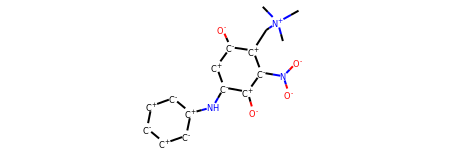

In [17]:
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
testmols = [molArr[i] for i in testidx]
testmols[-1]

In [26]:
#output for single molecule
test_probe = 5

#print([i for i in testidx])
bitInfo={}
fp = AllChem.GetMorganFingerprintAsBitVect(testmols[test_probe], 2, bitInfo=bitInfo)
arr = np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, arr)
onbit = [bit for bit in bitInfo.keys()]

importantonbits = list(set(onbit) & set([112]))
print(importantonbits)
#append to this array 
tpls = [(testmols[test_probe], x, bitInfo) for x in importantonbits]
#print(tpls[1][2])
no_repeat = {}


        
print(tpls)
Draw.DrawMorganBits(tpls)


[]
[]


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fc0418534d0>

In [19]:
test_probe = 5
tpls_full = []

#print([i for i in testidx])

for i in range(len(testmols)):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    onbit = [bit for bit in bitInfo.keys()]
    importantonbits = list(set(onbit) & set(top10feat))
    #append to this array 
    tpls.extend([(testmols[i], x, bitInfo) for x in importantonbits])

no_repeat = []
key_log = []

for i in range(len(testmols)):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    
    onbit = [bit for bit in bitInfo.keys()]
    temp_onbit = []
    temp_bitinfo = {}
    
    #filters for unique keys in array
    for keys in onbit:    
        if keys in key_log:
            pass
        else:
            temp_onbit.append(keys)
            key_log.append(keys)
            
    importantonbits = list(set(temp_onbit) & set(top25feat)) 
    
    #appends only new bitinfo arrays
    for i in importantonbits:
        temp_bitinfo[i] = bitInfo[i] 

    if (len(importantonbits) != 0): 
        print(len(importantonbits))
        print(len(temp_bitinfo))
        #print(importantonbits)
        #print(x)
        #print(bitInfo)
    
        no_repeat.extend([(testmols[i], x, temp_bitinfo) for x in importantonbits])

Draw.DrawMorganBits(tpls)


4
4
2
2
2
2
2
2
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
1


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fc031a799b0>

In [20]:
tpls_full = []

#print([i for i in testidx])


for i in range(len(testmols)-800):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    onbit = [bit for bit in bitInfo.keys()]
    importantonbits = list(set(onbit) & set(top10feat))
    importantonbits = list(set(onbit) & set([top10feat[10]]))
    #append to this array 
    if(len(importantonbits) > 0 ):
        tpls_full.extend([(testmols[i], x, bitInfo) for x in importantonbits])

no_repeat = []
key_log = []
Draw.DrawMorganBits(tpls_full)


IndexError: list index out of range

In [21]:
print(len(no_repeat))
print(len(tpls))
print(no_repeat)
#Draw.DrawMorganBits(no_repeat)

21
1452
[(<rdkit.Chem.rdchem.Mol object at 0x7fc0436833a0>, 80, {80: ((11, 0),), 389: ((15, 2),), 397: ((3, 2),), 967: ((3, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc0436833a0>, 389, {80: ((11, 0),), 389: ((15, 2),), 397: ((3, 2),), 967: ((3, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc0436833a0>, 397, {80: ((11, 0),), 389: ((15, 2),), 397: ((3, 2),), 967: ((3, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc0436833a0>, 967, {80: ((11, 0),), 389: ((15, 2),), 397: ((3, 2),), 967: ((3, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc0436996c0>, 715, {715: ((10, 0),), 747: ((0, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc0436996c0>, 747, {715: ((10, 0),), 747: ((0, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc04369fc60>, 628, {628: ((17, 1), (18, 1), (19, 1)), 319: ((16, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc04369fc60>, 319, {628: ((17, 1), (18, 1), (19, 1)), 319: ((16, 1),)}), (<rdkit.Chem.rdchem.Mol object at 0x7fc04367d5d0>, 318, {318: ((12, 2),), 271: ((16, 1), (10

In [22]:
top_feat = [x[:, i] for i in top10feat]
print(len(x[:,1]))
import pandas as pd 
df = pd.DataFrame(top_feat)
df = df.transpose()
df["HOMO"] = y
df.corr()
#print(np.shape(y))
#print(np.shape(np.delete(y, [267])))
#print(np.delete(np.delete(y, [6990]), [267]))
#df["HOMO"] = np.delete(y, [267])

6991


,0,1,2,3,4,5,6,7,8,9,HOMO
0,1.000000,-0.366968,0.070058,0.187280,0.419553,-0.543982,0.132741,0.115716,-0.327572,-0.152504,-0.516846
1,-0.366968,1.000000,-0.026895,-0.091480,-0.198514,0.360225,-0.088999,-0.035497,0.879995,-0.022364,-0.063825
2,0.070058,-0.026895,1.000000,-0.019846,0.004814,-0.072102,-0.015992,-0.013981,-0.009330,0.018387,0.185527
3,0.187280,-0.091480,-0.019846,1.000000,0.130564,-0.159234,-0.011680,-0.028599,-0.080145,0.020022,-0.252743
4,0.419553,-0.198514,0.004814,0.130564,1.000000,-0.463977,0.134487,0.082038,-0.172596,-0.089571,-0.116359
5,-0.543982,0.360225,-0.072102,-0.159234,-0.463977,1.000000,-0.133644,-0.142364,0.306795,0.112256,0.227497
6,0.132741,-0.088999,-0.015992,-0.011680,0.134487,-0.133644,1.000000,-0.014552,-0.077751,-0.045512,-0.200683
7,0.115716,-0.035497,-0.013981,-0.028599,0.082038,-0.142364,-0.014552,1.000000,-0.027003,-0.019238,-0.223635
8,-0.327572,0.879995,-0.009330,-0.080145,-0.172596,0.306795,-0.077751,-0.027003,1.000000,-0.044132,-0.089410
9,-0.152504,-0.022364,0.018387,0.020022,-0.089571,0.112256,-0.045512,-0.019238,-0.044132,1.000000,0.257121


['715', '674', '392', '1016', '319', '452', '746', '318', '112', '967']


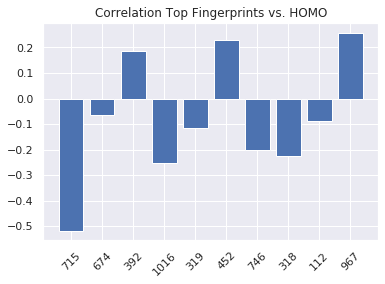

In [23]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
corr = np.array(df.corr()["HOMO"].to_numpy())[0:-1]
ax = plt.subplot(1,1,1)

plt.title("Correlation Top Fingerprints vs. HOMO")
ax.bar(range(10), corr)
print([str(i) for i in top10feat])
ax.set_xticklabels([str(i) for i in top10feat], rotation="45")
ax.set_xticks(np.arange(len(top10feat)))
plt.show()